In [83]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

df = pd.read_csv("470-data.csv")
# df = pd.read_csv("TrafficVolume.csv")
print(df.head())

   RequestID      Boro    Yr  M  D  HH  MM  Vol  SegmentID  \
0      23584  Brooklyn  2016  7  3  15   0  186     150372   
1      23584  Brooklyn  2016  7  3  15  15  207     150372   
2      23584  Brooklyn  2016  7  3  15  30  186     150372   
3      23584  Brooklyn  2016  7  3  15  45  170     150372   
4      23584  Brooklyn  2016  7  3  16   0  161     150372   

                                       WktGeom          street  \
0  POINT (997355.9816928023 208572.9762857783)  PULASKI BRIDGE   
1  POINT (997355.9816928023 208572.9762857783)  PULASKI BRIDGE   
2  POINT (997355.9816928023 208572.9762857783)  PULASKI BRIDGE   
3  POINT (997355.9816928023 208572.9762857783)  PULASKI BRIDGE   
4  POINT (997355.9816928023 208572.9762857783)  PULASKI BRIDGE   

                    fromSt      toSt Direction  
0  Newtown Creek Shoreline  Dead end        NB  
1  Newtown Creek Shoreline  Dead end        NB  
2  Newtown Creek Shoreline  Dead end        NB  
3  Newtown Creek Shoreline  Dead e

In [84]:
print(df.columns)
df = df.rename(columns={
    'Yr': 'year',
    'M': 'month',
    'D': 'day',
    'HH': 'hour',
    'MM': 'minute'
})

df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

df['weekday'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour
df['avg_vol_per_hour'] = df.groupby('hour')['Vol'].transform('mean')

df = df[['month', 'day', 'weekday', 'hour', 'minute', 'Vol', 'Direction', 'avg_vol_per_hour']]

# df['day_group'] = pd.cut(df['day'], bins=[0, 10, 20, 31], labels=['early', 'mid', 'late'])

print(df.head())

Index(['RequestID', 'Boro', 'Yr', 'M', 'D', 'HH', 'MM', 'Vol', 'SegmentID',
       'WktGeom', 'street', 'fromSt', 'toSt', 'Direction'],
      dtype='object')
   month  day weekday  hour  minute  Vol Direction  avg_vol_per_hour
0      7    3  Sunday    15       0  186        NB        170.688380
1      7    3  Sunday    15      15  207        NB        170.688380
2      7    3  Sunday    15      30  186        NB        170.688380
3      7    3  Sunday    15      45  170        NB        170.688380
4      7    3  Sunday    16       0  161        NB        173.598592


In [85]:
#One hot encoding categroical values

df['day_group'] = pd.cut(df['day'], bins=[0, 10, 20, 31], labels=['early', 'mid', 'late'])
df_encoded = pd.get_dummies(df, columns=['weekday', 'Direction', 'day_group'], drop_first=True)
print(df_encoded.head())

   month  day  hour  minute  Vol  avg_vol_per_hour  weekday_Monday  \
0      7    3    15       0  186        170.688380           False   
1      7    3    15      15  207        170.688380           False   
2      7    3    15      30  186        170.688380           False   
3      7    3    15      45  170        170.688380           False   
4      7    3    16       0  161        173.598592           False   

   weekday_Saturday  weekday_Sunday  weekday_Thursday  weekday_Tuesday  \
0             False            True             False            False   
1             False            True             False            False   
2             False            True             False            False   
3             False            True             False            False   
4             False            True             False            False   

   weekday_Wednesday  Direction_NB  Direction_SB  Direction_WB  day_group_mid  \
0              False          True         False     

MAE: 17.70
RMSE: 34.03
R² Score: 0.97
Linear Regression R²: 0.06209782501117389


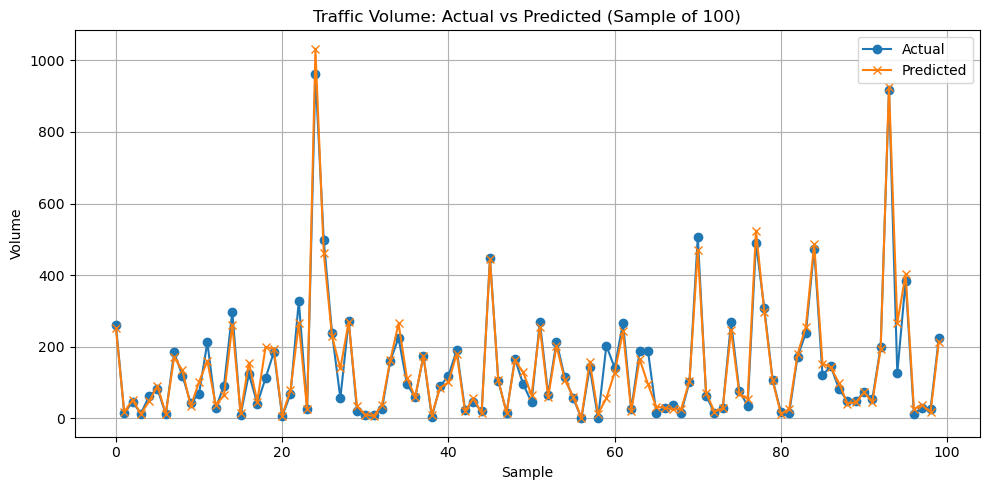

Train R²: 0.99
Test R²: 0.97
Cross-validated R² scores: [0.0936012  0.56342725 0.25348094 0.41814347 0.10232719]
Average CV R²: 0.2861960105268195


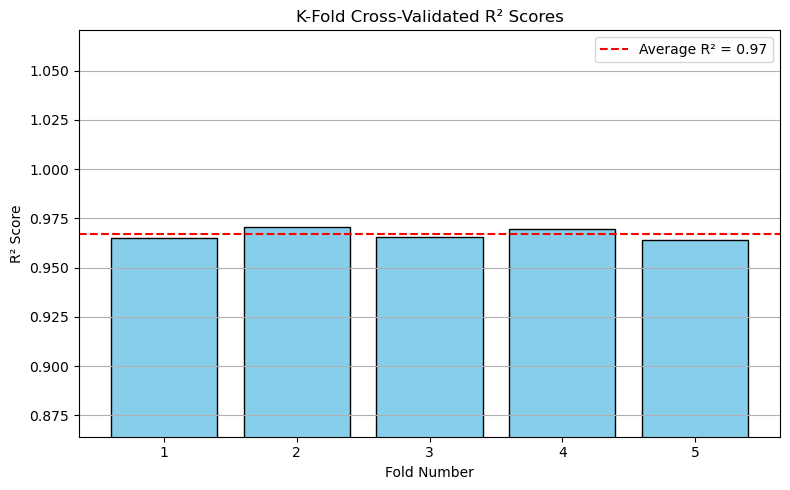

In [86]:
X = df_encoded.drop('Vol' , axis=1)
y = df_encoded['Vol']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Create and train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 4. Make predictions on the test set
predictions = model.predict(X_test)

# 5. Evaluate the model
mae = mean_absolute_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, lr_preds))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(predictions[:100], label='Predicted', marker='x')
plt.legend()
plt.title("Traffic Volume: Actual vs Predicted (Sample of 100)")
plt.xlabel("Sample")
plt.ylabel("Volume")
plt.grid(True)
plt.tight_layout()
plt.show()


r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)

print(f"Train R²: {r2_train:.2f}")
print(f"Test R²: {r2_test:.2f}")

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", cv_scores)
print("Average CV R²:", cv_scores.mean())



from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have X and y defined (features and target)
# Example: X = df_encoded.drop("Vol", axis=1), y = df_encoded["Vol"]

# 1. Set up KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestRegressor(random_state=42)

cv_scores = []

# 2. Loop through the folds
for train_index, test_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    r2 = r2_score(y_val, y_pred)
    cv_scores.append(r2)

# 3. Plot the scores
folds = np.arange(1, len(cv_scores) + 1)

plt.figure(figsize=(8, 5))
plt.bar(folds, cv_scores, color='skyblue', edgecolor='black')
plt.axhline(y=np.mean(cv_scores), color='red', linestyle='--', label=f'Average R² = {np.mean(cv_scores):.2f}')
plt.title('K-Fold Cross-Validated R² Scores')
plt.xlabel('Fold Number')
plt.ylabel('R² Score')
plt.xticks(folds)
plt.ylim(min(cv_scores) - 0.1, max(cv_scores) + 0.1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

day                  0.406315
month                0.173859
day_group_mid        0.100685
Direction_SB         0.086342
weekday_Saturday     0.055837
weekday_Tuesday      0.032123
Direction_NB         0.029778
Direction_WB         0.027989
weekday_Thursday     0.026907
weekday_Wednesday    0.023141
dtype: float64


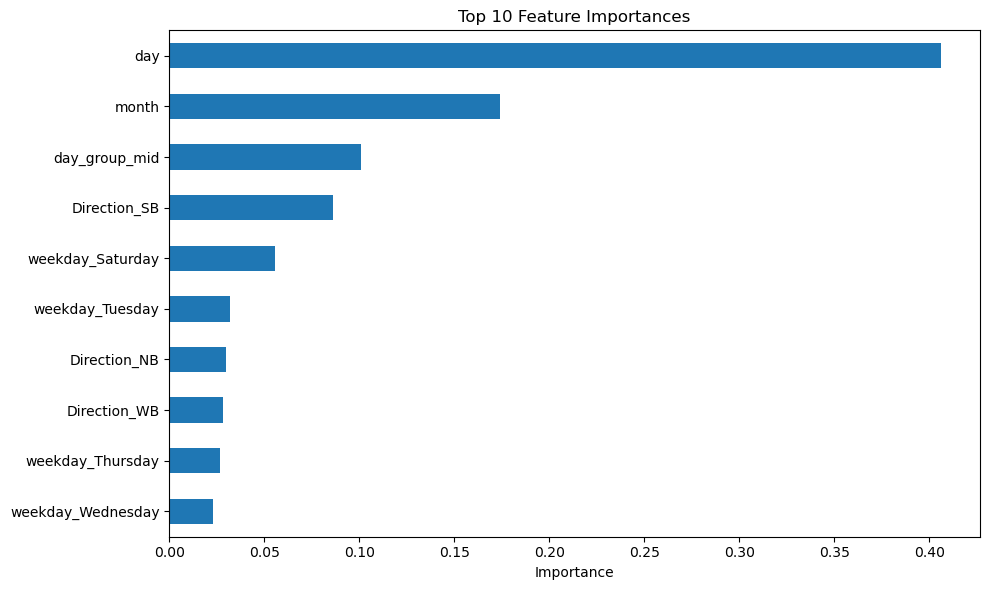

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the trained model
importances = model.feature_importances_

# Match importances to feature names
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names)

# Sort by importance (descending)
feat_imp = feat_imp.sort_values(ascending=False)

# Show the top features
print(feat_imp.head(10))

# Optional: Visualize
plt.figure(figsize=(10, 6))
feat_imp.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.gca().invert_yaxis()  # most important on top
plt.tight_layout()
plt.show()